##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>
</td>
</table>

このチュートリアルでは、花の画像を分類する方法を示します。`tf.keras.Sequential`モデルを使用して画像分類器を構築し、`tf.keras.utils.image_dataset_from_directory` を使用してデータを読み込みます。このチュートリアルでは、次の概念を実際に見ていきます。

- ディスク上のデータセットを効率的に読み込みます。
- 過学習を識別し、データ拡張やドロップアウトなどテクニックを使用して過学習を防ぎます。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

## パッケージのインポート

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## データの読み込み

このチュートリアルでは、約3,700枚の花の写真のデータセットを使用します。データセットには、クラスごとに1つずつ、5 つのサブディレクトリが含まれています。

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 4s 0us/step


ダウンロード後、データセットのコピーが利用できるようになります。合計3,670枚の画像があります。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


バラの画像です。

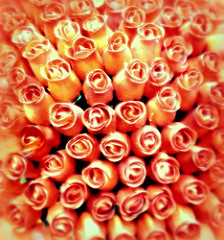

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

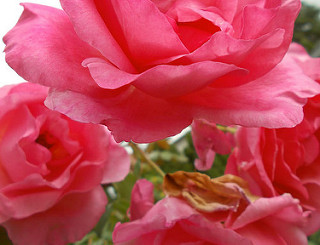

In [6]:
PIL.Image.open(str(roses[1]))

チューリップの画像です。

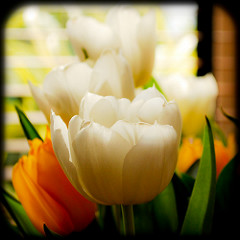

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

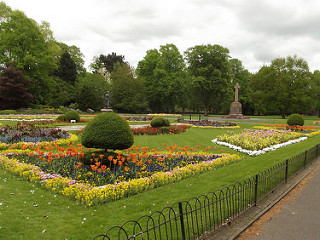

In [8]:
PIL.Image.open(str(tulips[1]))

# Keras ユーティリティを使用してデータを読み込む

便利な <a>image_dataset_from_directory</a> ユーティリティを使用して、これらの画像をディスクから読み込みます。これにより、数行のコードでディスク上の画像のディレクトリから`tf.data.Dataset`に移動します。また、[画像を読み込んで前処理する](../load_data/images.ipynb)チュートリアルにアクセスして、独自のデータ読み込みコードを最初から作成することもできます。

## データセットを作成する

ローダーのいくつかのパラメーターを定義します。

In [9]:
batch_size = 32
img_height = 180
img_width = 180

モデルを開発するときは、検証分割を使用することをお勧めします。ここでは、画像の80％をトレーニングに使用し、20％を検証に使用します。

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


クラス名は、これらのデータセットの`class_names`属性にあります。 これらはアルファベット順にディレクトリ名に対応します。

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## データを視覚化する

以下はトレーニングデータセットの最初の 9 枚の画像です。

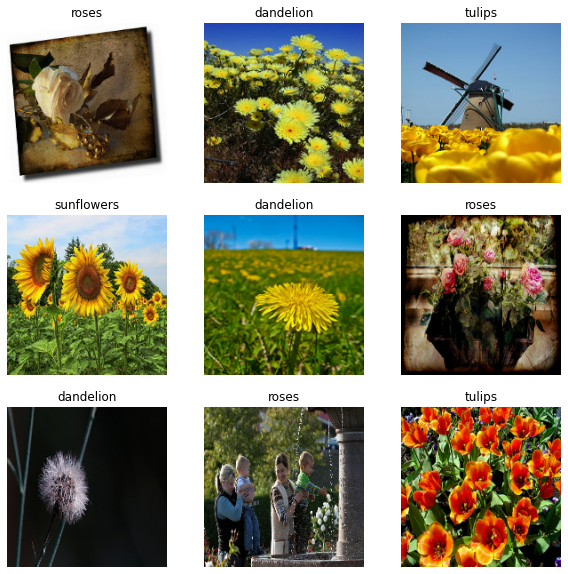

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

これらのデータセットを`model.fit`に渡すことで、これらのデータセットを使用してモデルをトレーニングします。 必要に応じて、データセットを手動で繰り返し、画像のバッチを取得することもできます。

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`は、形状`(32, 180, 180, 3)`のテンソルです。これは、形状`180x180x3`の 32 枚の画像のバッチです（最後の次元はカラーチャンネル RGB を参照します）。`label_batch`は、形状`(32,)`のテンソルであり、これらは 32 枚の画像に対応するラベルです。

`image_batch`および`labels_batch`テンソルで`.numpy()`を呼び出して、それらを`numpy.ndarray`に変換できます。


## パフォーマンスのためにデータセットを構成する

I/O がブロックされることなくディスクからデータを取得できるように、必ずバッファ付きプリフェッチを使用します。これらは、データを読み込むときに使用する必要がある 2 つの重要な方法です。

- `Dataset.cache()`は、最初のエポック中に画像をディスクから読み込んだ後、メモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。
- `Dataset.prefetch` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、<a>データパフォーマンスガイド</a>の <em>プリフェッチ</em>を参照してください。

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## データを標準化する

RGB チャネル値は `[0, 255]` の範囲にあり、ニューラルネットワークには理想的ではありません。一般に、入力値は小さくする必要があります。

ここでは、`tf.keras.layers.Rescaling` を使用して、値を `[0, 1]` の範囲に標準化します。

In [16]:
normalization_layer = layers.Rescaling(1./255)

このレイヤーを使用するには 2 つの方法があります。`Dataset.map` を呼び出すことにより、データセットに適用できます。

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


または、モデル定義内にレイヤーを含めることができます。これにより、デプロイメントを簡素化できます。 ここでは 2 番目のアプローチを使用します。

注意：以前は、`tf.keras.utils.image_dataset_from_directory` の `image_size` 引数を使用して画像のサイズを変更しました。モデルにサイズ変更ロジックも含める場合は、`tf.keras.layers.Resizing` レイヤーを使用できます。

# モデルを作成する

[Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、それぞれに最大プールレイヤー（`tf.keras.layers.MaxPooling2D`）を持つ3つの畳み込みブロック（`tf.keras.layers.Conv2D`）で構成されます。ReLU 活性化関数（`'relu'`）により活性化されたユニットが 128 個ある完全に接続されたレイヤー（`tf.keras.layers.Dense`）があります。このチュートリアルの目的は、標準的なアプローチを示すことなので、このモデルは高精度に調整されていません。

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## モデルをコンパイルする

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと`tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニングと検証の精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## モデルの概要

モデルの `Model.summary` メソッドを使用して、ネットワークのすべてのレイヤーを表示します。

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## モデルをトレーニングする

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 112s 1s/step - loss: 1.4287 - accuracy: 0.3832 - val_loss: 1.1002 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 96s 1s/step - loss: 0.9846 - accuracy: 0.6223 - val_loss: 0.9164 - val_accuracy: 0.6567
Epoch 3/10
92/92 [==============================] - 96s 1s/step - loss: 0.8161 - accuracy: 0.6914 - val_loss: 1.0461 - val_accuracy: 0.6035
Epoch 4/10
92/92 [==============================] - 97s 1s/step - loss: 0.6402 - accuracy: 0.7663 - val_loss: 1.0182 - val_accuracy: 0.6117
Epoch 5/10
92/92 [==============================] - 95s 1s/step - loss: 0.4338 - accuracy: 0.8426 - val_loss: 1.0306 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 96s 1s/step - loss: 0.2660 - accuracy: 0.9070 - val_loss: 1.1461 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 96s 1s/step - loss: 0.1502 - accuracy: 0.9547 - val_loss: 1.4046 - val_accuracy: 0.6076
Epoch 8/10
92/92 [=

## トレーニングの結果を視覚化する

トレーニングセットと検証セットで損失と精度のプロットを作成します。

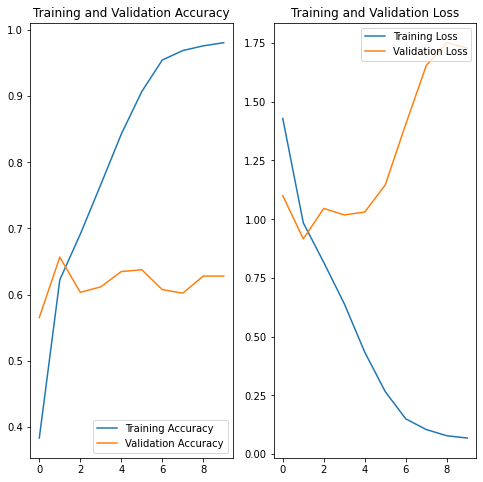

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

プロットには、トレーニングの精度と検証の精度は大幅にずれており、モデルは検証セットで約 60％ の精度しか達成していないことが示されています。

原因を調べ、モデルの全体的なパフォーマンスを向上させます。

## 過剰適合

上記のプロットでは、トレーニングの精度は時間の経過とともに直線的に増加していますが、検証の精度はトレーニングプロセスで約60％のままです。また、トレーニングと検証の精度に大きな違いがあり、これは[過剰適合](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)の兆候を示しています。

トレーニングサンプルの数が少ない場合、モデルは、トレーニングサンプルのノイズや不要な詳細から学習し、新しいサンプルでのモデルのパフォーマンスに悪影響を及ぼすことがあります。 この現象は過剰適合として知られています。 これは、モデルが新しいデータセットで一般化する上で問題があることを意味します。

トレーニングプロセスで過剰適合を回避する方法は複数あります。このチュートリアルでは、*データ拡張*を使用して、モデルに*ドロップアウト*を追加します。

## データ拡張

過剰適合は、一般に、トレーニングサンプルの数が少ない場合に発生します。[データ拡張](./data_augmentation.ipynb)は、既存のサンプルに対してランダムな変換を使用してサンプルを拡張することにより、追加のトレーニングデータを生成します。これにより、モデルをデータのより多くの側面でトレーニングし、より一般化することができます。

`tf.keras.layers.RandomFlip`、`tf.keras.layers.RandomRotation`、および `tf.keras.layers.RandomZoom` の前処理レイヤーを使用して、データ拡張を実装します。これらは、他のレイヤーと同様にモデル内に含めて、GPU で実行できます。

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

同じ画像にデータ拡張を数回適用して、いくつかの拡張されたデータがどのようになるかを視覚化してみましょう。

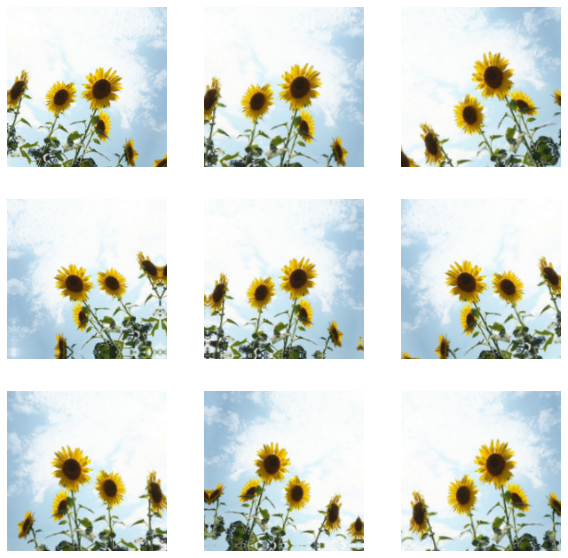

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

データ拡張を使用して、モデルをトレーニングします。

## ドロップアウト

過剰適合を回避するもう 1 つの方法は、[ドロップアウト](https://developers.google.com/machine-learning/glossary#dropout_regularization)正則化をネットワークに導入することです。

ドロップアウトをレイヤーに適用すると、トレーニングプロセス中にレイヤーからいくつかの出力ユニットがランダムにドロップアウトされます（アクティベーションをゼロに設定することにより）。ドロップアウトは、0.1、0.2、0.4 などの形式で、入力値として小数を取ります。これは、適用されたレイヤーから出力ユニットの 10％、20％、または 40％ をランダムにドロップアウトすることを意味します。

拡張された画像を使用してトレーニングする前に、`tf.keras.layers.Dropout` を使用して新しいニューラルネットワークを作成しましょう。

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## モデルをコンパイルしてトレーニングする

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 113s 1s/step - loss: 1.4596 - accuracy: 0.3372 - val_loss: 1.2623 - val_accuracy: 0.4687
Epoch 2/15
92/92 [==============================] - 109s 1s/step - loss: 1.1256 - accuracy: 0.5439 - val_loss: 1.1998 - val_accuracy: 0.5381
Epoch 3/15
92/92 [==============================] - 110s 1s/step - loss: 1.0106 - accuracy: 0.6093 - val_loss: 0.9616 - val_accuracy: 0.6158
Epoch 4/15
92/92 [==============================] - 110s 1s/step - loss: 0.9294 - accuracy: 0.6471 - val_loss: 0.9227 - val_accuracy: 0.6417
Epoch 5/15
92/92 [==============================] - 110s 1s/step - loss: 0.8805 - accuracy: 0.6655 - val_loss: 0.8924 - val_accuracy: 0.6499
Epoch 6/15
92/92 [==============================] - 110s 1s/step - loss: 0.8144 - accuracy: 0.6880 - val_loss: 0.8259 - val_accuracy: 0.6744
Epoch 7/15
92/92 [==============================] - 109s 1s/step - loss: 0.7645 - accuracy: 0.7108 - val_loss: 0.7996 - val_accuracy: 0.6730
Epoch 8/15
92

## トレーニングの結果を視覚化する

データ拡張と `tf.keras.layers.Dropout` を適用した後は、以前よりも過剰適合が少なくなり、トレーニングと検証がより高精度に調整されます。

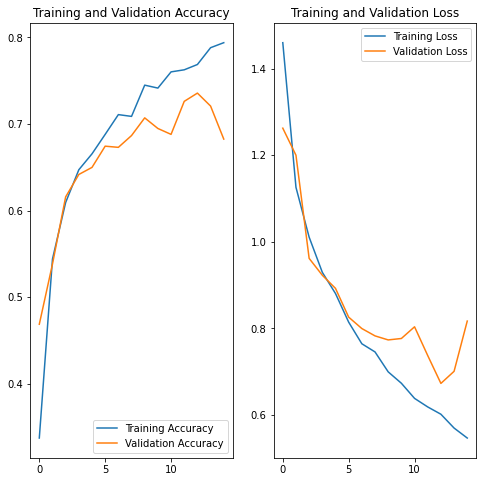

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 新しいデータを予測する

最後に、モデルを使用して、トレーニングセットまたは検証セットに含まれていなかった画像を分類します。

注意：データ拡張レイヤーとドロップアウトレイヤーは、推論時に非アクティブになります。

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 94.64 percent confidence.


##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

You will learn how to apply data augmentation in two ways:

- Use the Keras preprocessing layers, such as `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip`, and `tf.keras.layers.RandomRotation`.
- Use the `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Download a dataset

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about other ways of importing data, check out the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

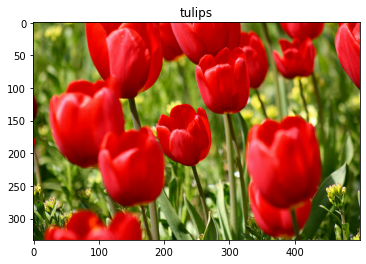

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

### Resizing and rescaling


You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


You can visualize the result of applying these layers to an image. 

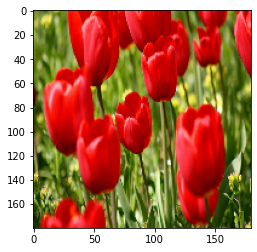

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the `[0, 1]` range:

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

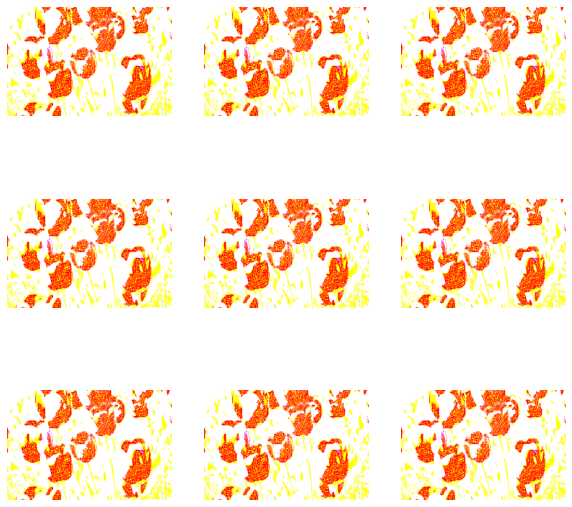

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, and others.

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [Image classification](classification.ipynb) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

Note: Data augmentation should only be applied to the training set.

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for a few epochs:

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 107s 1s/step - loss: 1.3367 - accuracy: 0.4097 - val_loss: 1.1480 - val_accuracy: 0.5313
Epoch 2/5
92/92 [==============================] - 102s 1s/step - loss: 1.0755 - accuracy: 0.5705 - val_loss: 1.1571 - val_accuracy: 0.5668
Epoch 3/5
92/92 [==============================] - 103s 1s/step - loss: 0.9773 - accuracy: 0.6117 - val_loss: 0.9227 - val_accuracy: 0.6485
Epoch 4/5
92/92 [==============================] - 102s 1s/step - loss: 0.9131 - accuracy: 0.6373 - val_loss: 0.8962 - val_accuracy: 0.6621
Epoch 5/5
92/92 [==============================] - 103s 1s/step - loss: 0.8609 - accuracy: 0.6485 - val_loss: 0.9403 - val_accuracy: 0.6349


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 298ms/step - loss: 0.8853 - accuracy: 0.6376
Accuracy 0.6376021504402161


### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

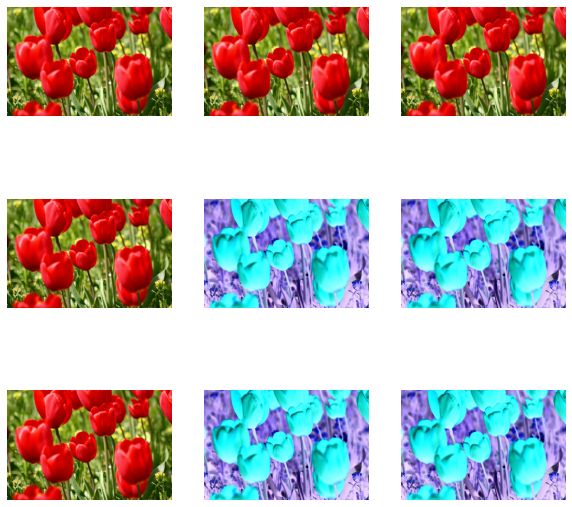

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

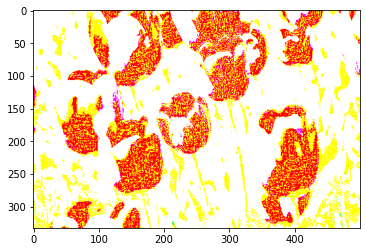

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. (You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace).)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with:

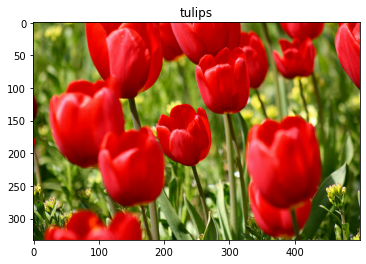

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flip an image

Flip an image either vertically or horizontally with `tf.image.flip_left_right`:

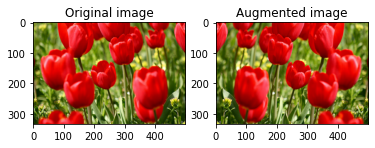

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with `tf.image.rgb_to_grayscale`:

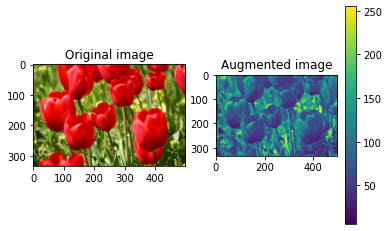

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with `tf.image.adjust_saturation` by providing a saturation factor:

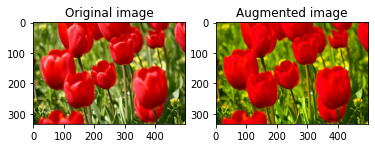

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with `tf.image.adjust_brightness` by providing a brightness factor:

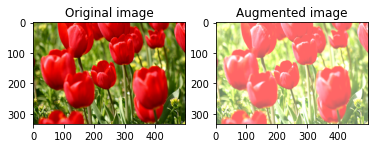

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using `tf.image.central_crop`:

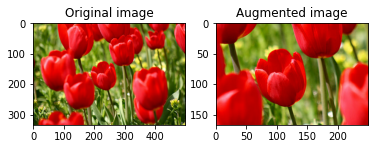

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with `tf.image.rot90`:

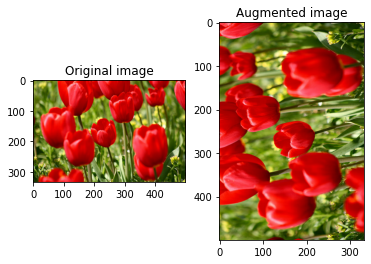

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations

Warning: There are two sets of random image operations: `tf.image.random*` and `tf.image.stateless_random*`. Using `tf.image.random*` operations is strongly discouraged as they use the old RNGs from TF 1.x. Instead, please use the random image operations introduced in this tutorial. For more information, refer to [Random number generation](../../guide/random_numbers.ipynb).

Applying random transformations to the images can further help generalize and expand the dataset. The current `tf.image` API provides eight such random image operations (ops):

*   [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
*   [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
*   [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
*   [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
*   [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
*   [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
*   [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
*   [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

These random image ops are purely functional: the output only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a `seed` value be input each step. Given the same `seed`, they return the same results independent of how many times they are called.

Note: `seed` is a `Tensor` of shape `(2,)`  whose values are any integers.

In the following sections, you will:
1.   Go over examples of using random image operations to transform an image.
2.   Demonstrate how to apply random transformations to a training dataset.

#### Randomly change image brightness

Randomly change the brightness of `image` using `tf.image.stateless_random_brightness` by providing a brightness factor and `seed`. The brightness factor is chosen randomly in the range `[-max_delta, max_delta)` and is associated with the given `seed`.

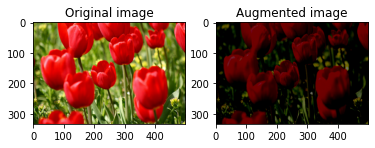

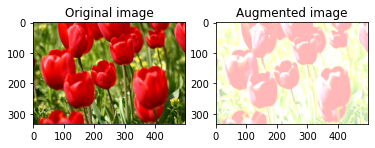

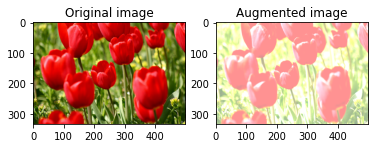

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### Randomly change image contrast

Randomly change the contrast of `image` using `tf.image.stateless_random_contrast` by providing a contrast range and `seed`. The contrast range is chosen randomly in the interval `[lower, upper]` and is associated with the given `seed`.

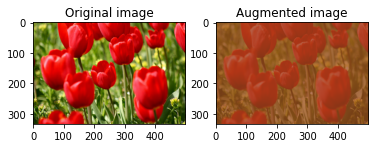

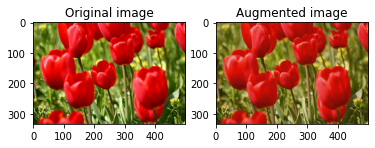

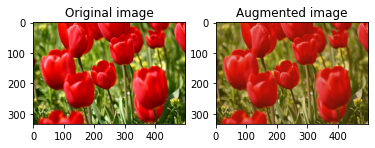

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### Randomly crop an image

Randomly crop `image` using `tf.image.stateless_random_crop` by providing target `size` and `seed`. The portion that gets cropped out of `image` is at a randomly chosen offset and is associated with the given `seed`.

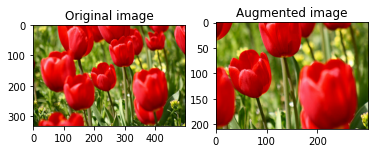

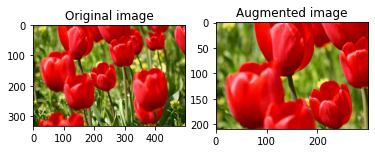

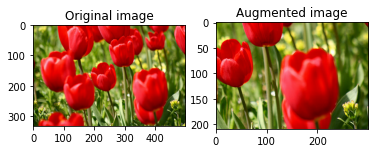

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Next, define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the `augment` function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 1: Using tf.data.experimental.Counter

Create a `tf.data.experimental.Counter` object (let's call it `counter`) and `Dataset.zip` the dataset with `(counter, counter)`. This will ensure that each image in the dataset gets associated with a unique value (of shape `(2,)`) based on `counter` which later can get passed into the `augment` function as the `seed` value for random transformations.

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the `augment` function to the training dataset:

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### Option 2: Using tf.random.Generator

- Create a `tf.random.Generator` object with an initial `seed` value. Calling the `make_seeds` function on the same generator object always returns a new, unique `seed` value.
- Define a wrapper function that: 1) calls the `make_seeds` function; and 2) passes the newly generated `seed` value into the `augment` function for random transformations.

Note: `tf.random.Generator` objects store RNG state in a `tf.Variable`, which means it can be saved as a [checkpoint](../../guide/checkpoint.ipynb) or in a [SavedModel](../../guide/saved_model.ipynb). For more details, please refer to [Random number generation](../../guide/random_numbers.ipynb).

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

Map the wrapper function `f` to the training dataset, and the `resize_and_rescale` function—to the validation and test sets:

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## Next steps

This tutorial demonstrated data augmentation using Keras preprocessing layers and `tf.image`.

- To learn how to include preprocessing layers inside your model, refer to the [Image classification](classification.ipynb) tutorial.
- You may also be interested in learning how preprocessing layers can help you classify text, as shown in the [Basic text classification](../keras/text_classification.ipynb) tutorial.
- You can learn more about `tf.data` in this [guide](../../guide/data.ipynb), and you can learn how to configure your input pipelines for performance [here](../../guide/data_performance.ipynb).